### Chest X-Ray Images (Pneumonia) Detection Using Convolutional Neural Networks with pytorch


**Introduction:**

Image Classification is an approach that is being widely utilised for different purposes in the realm of medical imaging and diagnostics. Pneumonia, a potentially life-threatening respiratory infection, poses a significant global health challenge, and rapid and accurate diagnosis is paramount for effective treatment. In an era where healthcare technology is advancing at an unprecedented pace, the importance of this method can't be overstated.Convolutional Neural Networks (CNNs) have emerged as a powerful image classification tool in image analysis, which can also be utilised to detect Pneumonia in Chest X-Ray Images which provides the capabilities to healthcare professionals in identifying pneumonia in diverse clinical scenarios, from crowded emergency rooms to remote telemedicine consultations in real-time.



**Dataset:**

- The dataset is divided into three folders - 'train', 'test', and 'val', and it contains subfolders for different image categories, specifically 'Pneumonia' and 'Normal'. There are a total of 5,863 X-Ray images in JPEG format, falling into these two categories.

- These chest X-ray images were obtained from pediatric patients aged one to five years old. These images were collected at the Guangzhou Women and Children’s Medical Center in Guangzhou, China, as part of their routine clinical care.

- To ensure the quality of the chest X-ray images, they were initially screened to remove any low-quality or unreadable scans. After this, two expert physicians examined and graded the diagnoses before using them to train the AI system. To further ensure accuracy, a third expert checked the evaluation set to account for any grading errors in the diagnoses.

Link to the data card on Kaggle: [Chest X-Ray Images (Pneumonia)](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/data)

Link to second Dataset on Kaggle: [COVID-19_Radiography_Dataset](https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database)

Installing and Importing Dependencies

In [5]:
import os

# Specify the directory you want to check
directory = '../chest_xray/train/NORMAL'

# Count the number of files
file_count = len([name for name in os.listdir(directory) if os.path.isfile(os.path.join(directory, name))])
print(f'There are {file_count} files in the directory.')


There are 4341 files in the directory.


In [6]:
# Specify the directory you want to check
directory = '../chest_xray/train/PNEUMONIA'

# Count the number of files
file_count = len([name for name in os.listdir(directory) if os.path.isfile(os.path.join(directory, name))])
print(f'There are {file_count} files in the directory.')


There are 3875 files in the directory.


Importing Modules

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, ConcatDataset, random_split, SubsetRandomSampler
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd

from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

import os
import json
import gc
import pathlib

import warnings
warnings.filterwarnings('ignore')

In [8]:
def calculate_transforms(data_dir):
    # Modify this line to ensure the dataset's transform converts images to tensors
    train_dataset = datasets.ImageFolder(data_dir+"train/", transform=transforms.ToTensor())
    first_train_image, _ = train_dataset[0]

    # Make sure first_train_image is a tensor before calling unsqueeze
    if isinstance(first_train_image, Image.Image):
        first_train_image = transforms.ToTensor()(first_train_image)

    first_train_image = first_train_image.unsqueeze(0)  # Add batch dimension
    grid_image = make_grid(first_train_image, normalize=True)  # Create a grid to get a single image

    # Compute mean and std for the first test image
    mean = grid_image.mean(dim=[1,2])
    std = grid_image.std(dim=[1,2])

    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomRotation(10),
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.RandomAffine(0, translate=(0.1, 0.1)),
            transforms.ToTensor(),
            transforms.Normalize(mean.tolist(), std.tolist())
        ]),
        'val': transforms.Compose([
            transforms.Resize(size=(224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean.tolist(), std.tolist())
        ]),
    }

    # Save the transform parameters to a json file for future use
    transform_parameters = {"mean": mean.tolist(), "std": std.tolist()}
    with open('transform_parameters.json', 'w') as f:
        json.dump(transform_parameters, f)

    return data_transforms


# def get_data_loaders(data_dir: str, data_transforms: dict, batch_size: int = 64):
#     # Loading the datasets with transformations
#     train_dataset = datasets.ImageFolder(data_dir+"train/", transform=data_transforms['train'])
#     test_dataset = datasets.ImageFolder(data_dir+"test/", transform=data_transforms['val'])
#     val_dataset = datasets.ImageFolder(data_dir+"val/", transform=data_transforms['val'])

#     # Data loaders
#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#     test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
#     val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

#     return train_dataset, test_dataset, val_dataset, train_loader, test_loader, val_loader

In [9]:
from torch.utils.data import random_split

def get_data_loaders(data_dir: str, data_transforms: dict, batch_size: int = 4):
    # Loading the datasets with transformations
    full_train_dataset = datasets.ImageFolder(data_dir+"train/", transform=data_transforms['train'])
    test_dataset = datasets.ImageFolder(data_dir+"test/", transform=data_transforms['val'])

    # Calculate the lengths for train and validation datasets (80-20 split)
    train_len = int(len(full_train_dataset) * 0.8)
    val_len = len(full_train_dataset) - train_len

    # Randomly split the full training dataset into training and validation datasets
    train_dataset, val_dataset = random_split(full_train_dataset, [train_len, val_len])

    # Data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_dataset, test_dataset, val_dataset, train_loader, test_loader, val_loader


In [11]:
data_dir = "../chest_xray/"
data_transforms = calculate_transforms(data_dir)
train_dataset, test_dataset, val_dataset, train_loader, test_loader, val_loader = get_data_loaders(data_dir, data_transforms)

In [12]:
def count_different_image_types(path):
    subdirectories = [subdir.name for subdir in os.scandir(path) if subdir.is_dir()]
    num_image_types = len(subdirectories)
    print("Number of different types of images found:", num_image_types)
    print("Types of images detected:")
    for i, image_type in enumerate(subdirectories, start=1):
        print(f"{i}. {image_type}")

count_different_image_types('../chest_xray/train')
count_different_image_types('../chest_xray/test')
count_different_image_types('../chest_xray/val')

Number of different types of images found: 2
Types of images detected:
1. PNEUMONIA
2. NORMAL
Number of different types of images found: 2
Types of images detected:
1. PNEUMONIA
2. NORMAL
Number of different types of images found: 2
Types of images detected:
1. PNEUMONIA
2. NORMAL


In [13]:
# define functions for getting class distribution plots and sumary stats
def plot_class_distribution(data, data_name):
    class_names = ['NORMAL', 'PNEUMONIA']
    class_counts = torch.zeros(len(class_names))

    for _, y in data:
        class_counts[y] += 1

    plt.bar(class_names, class_counts)
    plt.xlabel("Class")
    plt.ylabel("Number of images")
    plt.title(f"Class distribution in the {data_name} dataset")
    plt.show()

def summary_stats(dataset):
    mean = torch.zeros(3)
    std = torch.zeros(3)

    for x, _ in dataset:
        mean += x.mean(dim=(1, 2))  # Compute mean along channels
        std += x.std(dim=(1, 2))  # Compute std along channels

    mean /= len(dataset)
    std /= len(dataset)

    return mean.tolist(), std.tolist()


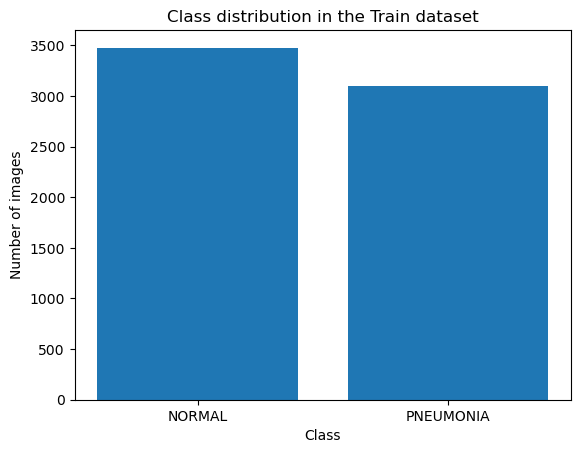

Train dataset mean: [-0.04715794697403908, -0.04715794697403908, -0.04715794697403908], standard deviation: [0.9458538889884949, 0.9458538889884949, 0.9458538889884949]


In [14]:
plot_class_distribution(train_dataset, "Train")
mean, std = summary_stats(train_dataset)
print(f"Train dataset mean: {mean}, standard deviation: {std}")

In [15]:
def get_model(device):
    """
    Function to get the model.
    """
    class CNNModel(nn.Module):
        def __init__(self):
            super(CNNModel, self).__init__()
            self.conv1 = nn.Conv2d(3, 8, kernel_size=7, padding=3)
            self.conv2 = nn.Conv2d(8, 8, kernel_size=7, padding=3)
            self.pool1 = nn.MaxPool2d(kernel_size=3, stride=3)

            self.conv3 = nn.Conv2d(8, 16, kernel_size=5, padding=2)
            self.conv4 = nn.Conv2d(16, 16, kernel_size=5, padding=2)
            self.pool2 = nn.MaxPool2d(kernel_size=3, stride=3)

            self.conv5 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
            self.conv6 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
            self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

            self.conv7 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
            self.conv8 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
            self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

            self.conv9 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
            self.conv10 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
            self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)

            self.adaptive_pool = nn.AdaptiveAvgPool2d((7, 7))
            self.flatten = nn.Flatten()
            self.fc1 = nn.Linear(128*7*7, 128)
            self.dropout = nn.Dropout(0.2)
            self.fc2 = nn.Linear(128, 2)

        def forward(self, x):
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = self.pool1(x)

            x = F.relu(self.conv3(x))
            x = F.relu(self.conv4(x))
            x = self.pool2(x)

            x = F.relu(self.conv5(x))
            x = F.relu(self.conv6(x))
            x = self.pool3(x)

            x = F.relu(self.conv7(x))
            x = F.relu(self.conv8(x))
            x = self.pool4(x)

            x = F.relu(self.conv9(x))
            x = F.relu(self.conv10(x))
            x = self.pool5(x)

            x = self.adaptive_pool(x)
            x = self.flatten(x)
            x = F.relu(self.fc1(x))
            x = self.dropout(x)
            x = self.fc2(x)
            return x

    model = CNNModel().to(device)
    return model

In [28]:

def train_model(model, train_loader, val_loader, device, num_epochs=10, learning_rate=0.0001):
    """
    Function to train the model.
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_val_loss = float("inf")
    train_loss_history, val_loss_history = [], []
    train_accuracy_history, val_accuracy_history = [], []

    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = 100 * correct / total
        train_loss = running_loss / len(train_loader)
        train_loss_history.append(train_loss)
        train_accuracy_history.append(train_accuracy)

        # Validation
        model.eval()
        running_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = 100 * correct / total
        val_loss = running_loss / len(val_loader)
        val_loss_history.append(val_loss)
        val_accuracy_history.append(val_accuracy)

        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

        # Create a directory if not exists
        saved_models_dir = 'saved_models'
        if not os.path.exists(saved_models_dir):
            os.makedirs(saved_models_dir)

        # Save the model if it has the best validation loss so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_path = os.path.join(saved_models_dir, 'best_model.pth')
            torch.save(model.state_dict(), best_model_path)
            print('Model checkpoint saved at {}'.format(best_model_path))

    return model, train_loss_history, train_accuracy_history, val_loss_history, val_accuracy_history


In [29]:
def evaluate_model(model, test_loader, device, class_names):
    """
    Function to evaluate the model.
    """
    model.eval()
    correct, total = 0, 0
    true_labels, pred_labels = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total

    # Classification report
    print('Classification Report:')
    print(classification_report(true_labels, pred_labels, target_names=class_names))

    # Confusion matrix
    conf_matrix = confusion_matrix(true_labels, pred_labels)
    df_cm = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)
    plt.figure(figsize=(5,5))
    sns.heatmap(df_cm, annot=True, fmt="d", cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig("confusion_matrix.png")
    plt.show()

    return accuracy, true_labels, pred_labels

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_dir = "../chest_xray/"
num_epochs = 10
batch_size = 4

In [31]:
class_names = ['NORMAL', 'PNEUMONIA']

In [ ]:
# import torch
# import gc

# # 1. Delete the prvious model model
# del model

# # 2. Empty the cache from CUDA
# torch.cuda.empty_cache()

# # 3. Use Python's garbage collector
# gc.collect()

In [32]:
model = get_model(device)

In [33]:
model, train_loss, train_acc, val_loss, val_acc = train_model(model, train_loader, val_loader, device, num_epochs)

Epoch 1/10, Train Loss: 0.5630, Train Acc: 70.42%, Val Loss: 0.4621, Val Acc: 77.19%
Model checkpoint saved at saved_models/best_model.pth
Epoch 2/10, Train Loss: 0.4514, Train Acc: 78.20%, Val Loss: 0.5318, Val Acc: 73.54%
Epoch 3/10, Train Loss: 0.4075, Train Acc: 81.13%, Val Loss: 0.4231, Val Acc: 81.20%
Model checkpoint saved at saved_models/best_model.pth
Epoch 4/10, Train Loss: 0.3775, Train Acc: 83.06%, Val Loss: 0.3778, Val Acc: 82.18%
Model checkpoint saved at saved_models/best_model.pth
Epoch 5/10, Train Loss: 0.3599, Train Acc: 84.02%, Val Loss: 0.3883, Val Acc: 82.30%
Epoch 6/10, Train Loss: 0.3531, Train Acc: 84.71%, Val Loss: 0.3219, Val Acc: 86.74%
Model checkpoint saved at saved_models/best_model.pth
Epoch 7/10, Train Loss: 0.3405, Train Acc: 84.74%, Val Loss: 0.3637, Val Acc: 83.27%
Epoch 8/10, Train Loss: 0.3410, Train Acc: 85.19%, Val Loss: 0.3428, Val Acc: 84.55%
Epoch 9/10, Train Loss: 0.3253, Train Acc: 86.26%, Val Loss: 0.3162, Val Acc: 86.44%
Model checkpoint sa

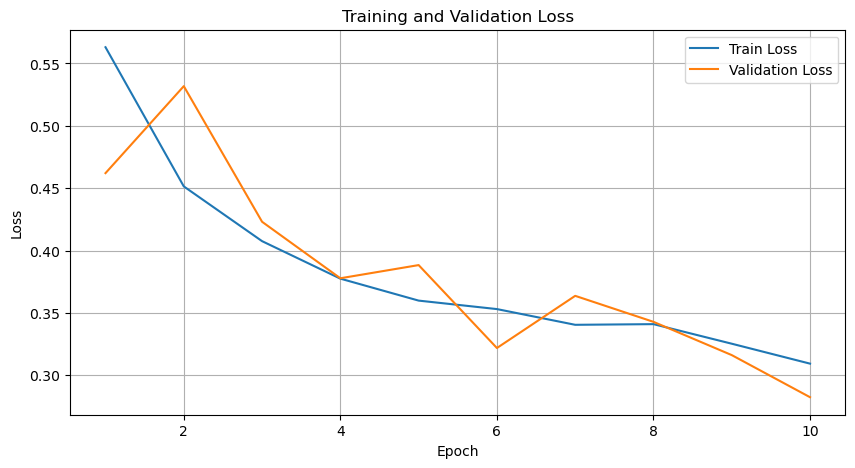

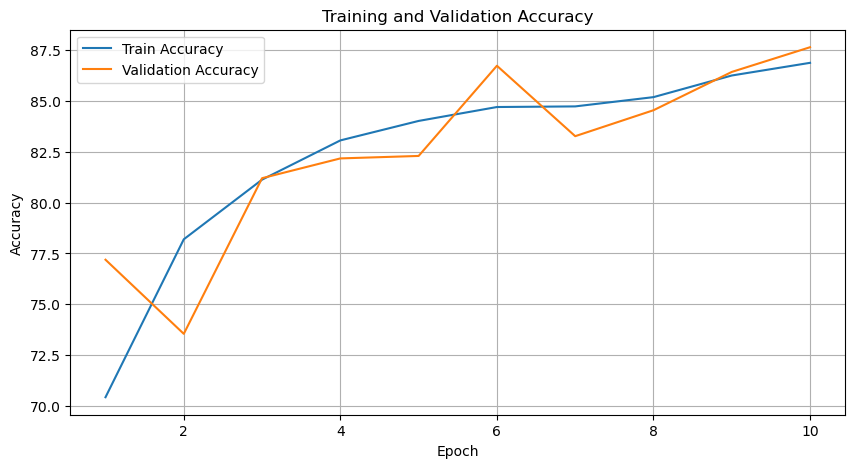

In [34]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_loss, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.savefig("validation_train loss.png")
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_acc, label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), val_acc, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid(True)
plt.savefig("validation_train accuracy.png")
plt.show()

In [35]:
ls

app.py
confusion_matrix.png
model_app_CNN_ganeshghimir (1).ipynb
model_app_CNN_ganeshghimir_gradCAM.ipynb
new_model_app_CNN_ganeshghimir.html
saved_models/
transform_parameters.json
validation_train accuracy.png
validation_train loss.png


In [36]:
checkpoint_path = 'saved_models/best_model.pth'
# Load the best model checkpoint
best_model = get_model(device)
best_model.load_state_dict(torch.load(checkpoint_path))

<All keys matched successfully>

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.68      0.88      0.77       234
   PNEUMONIA       0.92      0.75      0.83       390

    accuracy                           0.80       624
   macro avg       0.80      0.82      0.80       624
weighted avg       0.83      0.80      0.80       624



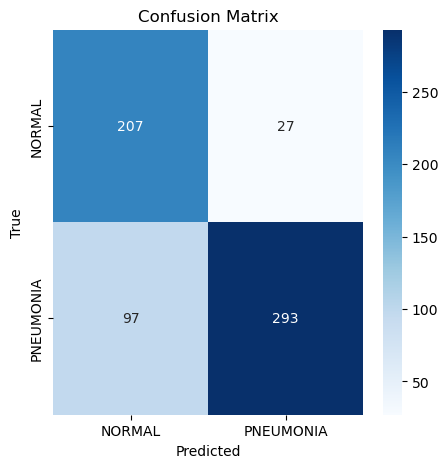

Test Accuracy: 80.12820512820512%


In [37]:
accuracy, true_labels, pred_labels = evaluate_model(best_model, test_loader, device, class_names)
print(f'Test Accuracy: {accuracy}%')

# **Custom Grad CAM Implementation**

In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function
import numpy as np
import matplotlib.pyplot as plt
import cv2
import json
from torchvision import transforms
from PIL import Image


In [47]:
# GradCam Class
class CustomGradCam:
    def __init__(self, model):
        self.model = model
        self.gradients = None
        self.forward_output = None
        self.model.eval()

        def forward_hook(module, input, output):
            self.forward_output = output

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]

        self.hook_forward = self.model.conv10.register_forward_hook(forward_hook)
        self.hook_backward = self.model.conv10.register_backward_hook(backward_hook)

    def generate_cam(self, input_image, target_class):
        model_output = self.model(input_image)
        self.model.zero_grad()
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        model_output.backward(gradient=one_hot_output.to(input_image.device))
        gradients = self.gradients.data.cpu().numpy()[0]
        forward_output = self.forward_output.data.cpu().numpy()[0]
        weights = np.mean(gradients, axis=(1, 2))
        cam = np.zeros(forward_output.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            cam += w * forward_output[i, :, :]
        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (input_image.shape[2], input_image.shape[3]))
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam

    def close(self):
        self.hook_forward.remove()
        self.hook_backward.remove()

In [48]:
# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint_path = 'saved_models/best_model.pth'
best_model = get_model(device)
best_model.load_state_dict(torch.load(checkpoint_path))
best_model.eval()

CNNModel(
  (conv1): Conv2d(3, 8, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (conv2): Conv2d(8, 8, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (pool1): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv9): Conv2d(64, 128, kernel_s

In [49]:
# Load the mean and std from the saved json file
with open('transform_parameters.json', 'r') as f:
    transform_params = json.load(f)
    mean = transform_params['mean']
    std = transform_params['std']

# Define the validation transform using the loaded mean and std
val_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [50]:
# Function to apply Grad-CAM to any given image
def apply_custom_grad_cam(image_path, grad_cam, model, alpha=0.4):
    # Load and transform the image
    image = Image.open(image_path).convert('RGB')  # Convert image to RGB if it's not
    transformed_image = val_transform(image).to(device)

    # Convert image to numpy for visualization
    original_image = np.array(image)
    original_image = original_image / 255.0  # Normalize to [0,1]

    # Prepare image for model input
    input_image = transformed_image.unsqueeze(0)

    # Perform a prediction to find the target class
    model_output = model(input_image)
    predicted_class = model_output.argmax(dim=1).item()

    # Generate CAM for the predicted class
    cam = grad_cam.generate_cam(input_image, predicted_class)

    # Normalize CAM to 0-1 range and convert to 8-bit format
    cam = cam - np.min(cam)
    cam = cam / np.max(cam)
    cam_8bit = np.uint8(255 * cam)

    # Apply Histogram Equalization
    cam_eq = cv2.equalizeHist(cam_8bit)

    # Resize CAM to original image size
    cam_resized = cv2.resize(cam_eq, (original_image.shape[1], original_image.shape[0]))
    heatmap = cv2.applyColorMap(cam_resized, cv2.COLORMAP_JET)  # Apply heatmap color
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)  # Convert to RGB

    # Superimpose the heatmap on original image
    superimposed_img = heatmap * alpha + original_image * (1 - alpha)
    superimposed_img = np.clip(superimposed_img, 0, 1)

    # Display the image
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.title(f'Predicted Class: {predicted_class}')
    plt.show()



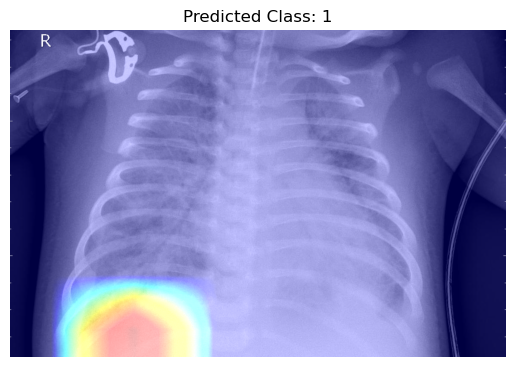

In [53]:

# Using grad cam
grad_cam = CustomGradCam(best_model)
# Using grad cam with adjusted opacity
alpha_value = 0.002
apply_custom_grad_cam('/Users/ganeshghimire/Documents/github/capstone/testimages/person1000_bacteria_2931.jpeg', grad_cam, best_model, alpha=alpha_value)


In [ ]:
# !pip install pytorch-gradcam

# using Pytroch Builtin GradCAM

In [38]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 45.5 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.8-py3-none-any.whl size=38244 sha256=4c63eb32e95f8fc823d66dadda7b0e96bc8728510ff4cb93cfd1b6fda548b710
  Stored in directory: /Users/ganeshghimire/Library/Caches/pip/wheels/17/3d/6a/ccba262e99e4fdc1a5b859c8e4badff4fcf76799fecd6fc03d
Successfully built grad-cam


In [39]:
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import json
import cv2


In [41]:

# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint_path = 'saved_models/best_model.pth'
best_model = get_model(device)  # Make sure you have defined the get_model function
best_model.load_state_dict(torch.load(checkpoint_path))
best_model.eval()


CNNModel(
  (conv1): Conv2d(3, 8, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (conv2): Conv2d(8, 8, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (pool1): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv9): Conv2d(64, 128, kernel_s

In [42]:

with open('transform_parameters.json', 'r') as f:
    transform_params = json.load(f)
    mean = transform_params['mean']
    std = transform_params['std']

val_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


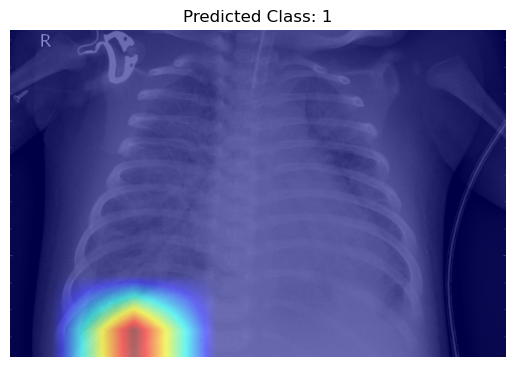

In [54]:

def apply_grad_cam(test_img_path, model, target_layer):
    # Load and preprocess the image
    image = Image.open(test_img_path).convert('RGB')
    transformed_image = val_transform(image).unsqueeze(0).to(device)

    # Get the model's prediction
    model_output = model(transformed_image)
    predicted_class = model_output.argmax(dim=1).item()

    # Initialize Grad-CAM and generate CAM mask
    target_layers = [target_layer]
    cam = GradCAM(model=model, target_layers=target_layers, use_cuda=device.type == 'cuda')

    # Specify the target class as the model's prediction
    targets = [ClassifierOutputTarget(predicted_class)]
    grayscale_cam = cam(input_tensor=transformed_image, targets=targets)[0, :]

    # Resize grayscale_cam to match the original image size
    grayscale_cam_resized = cv2.resize(grayscale_cam, (image.width, image.height))

    # Postprocess and show the image
    cam_image = show_cam_on_image(np.array(image)/255.0, grayscale_cam_resized, use_rgb=True)
    plt.imshow(cam_image)
    plt.axis('off')
    plt.title(f'Predicted Class: {predicted_class}')
    plt.show()



# Usage
test_img_path = '/Users/ganeshghimire/Documents/github/capstone/testimages/person1000_bacteria_2931.jpeg'
apply_grad_cam(test_img_path, best_model, best_model.conv10)


# **To run Streamlit App in Colab** Run below cells.

In [ ]:
# !pip install -q streamlit
# !pip install grad-cam

In [ ]:
# %%writefile app.py
# import streamlit as st
# import torch
# from PIL import Image
# import json
# import matplotlib.pyplot as plt
# from torchvision import transforms
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import torch.nn.functional as F
# from torch.utils.data import DataLoader, ConcatDataset, random_split, SubsetRandomSampler
# import torchvision.datasets as datasets
# import torchvision.transforms as transforms
# from torchvision.utils import make_grid
# from sklearn.metrics import classification_report, confusion_matrix
# import numpy as np
# import pandas as pd
# import torch
# from torchvision import transforms
# from PIL import Image
# import numpy as np
# import matplotlib.pyplot as plt
# from pytorch_grad_cam import GradCAM
# from pytorch_grad_cam.utils.image import show_cam_on_image
# from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
# import json
# import cv2
# from pytorch_grad_cam import GradCAM
# from pytorch_grad_cam.utils.image import show_cam_on_image
# from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
# # import other necessary modules

# def get_model(device):
#     """
#     Function to get the model.
#     """
#     class CNNModel(nn.Module):
#         def __init__(self):
#             super(CNNModel, self).__init__()
#             self.conv1 = nn.Conv2d(3, 8, kernel_size=7, padding=3)
#             self.conv2 = nn.Conv2d(8, 8, kernel_size=7, padding=3)
#             self.pool1 = nn.MaxPool2d(kernel_size=3, stride=3)

#             self.conv3 = nn.Conv2d(8, 16, kernel_size=5, padding=2)
#             self.conv4 = nn.Conv2d(16, 16, kernel_size=5, padding=2)
#             self.pool2 = nn.MaxPool2d(kernel_size=3, stride=3)

#             self.conv5 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
#             self.conv6 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
#             self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

#             self.conv7 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
#             self.conv8 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
#             self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

#             self.conv9 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
#             self.conv10 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
#             self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)

#             self.adaptive_pool = nn.AdaptiveAvgPool2d((7, 7))
#             self.flatten = nn.Flatten()
#             self.fc1 = nn.Linear(128*7*7, 128)
#             self.dropout = nn.Dropout(0.2)
#             self.fc2 = nn.Linear(128, 2)

#         def forward(self, x):
#             x = F.relu(self.conv1(x))
#             x = F.relu(self.conv2(x))
#             x = self.pool1(x)

#             x = F.relu(self.conv3(x))
#             x = F.relu(self.conv4(x))
#             x = self.pool2(x)

#             x = F.relu(self.conv5(x))
#             x = F.relu(self.conv6(x))
#             x = self.pool3(x)

#             x = F.relu(self.conv7(x))
#             x = F.relu(self.conv8(x))
#             x = self.pool4(x)

#             x = F.relu(self.conv9(x))
#             x = F.relu(self.conv10(x))
#             x = self.pool5(x)

#             x = self.adaptive_pool(x)
#             x = self.flatten(x)
#             x = F.relu(self.fc1(x))
#             x = self.dropout(x)
#             x = self.fc2(x)
#             return x

#     model = CNNModel().to(device)
#     return model

# # Load your trained model
# def load_model(model_path):
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     model = get_model(device)  # your get_model function
#     model.load_state_dict(torch.load(model_path, map_location=device))
#     model.eval()
#     return model

# # Global variables for mean and std
# mean = None
# std = None

# # Function to process an uploaded image
# def process_image(uploaded_file, device):
#     global mean, std
#     # Open the image file
#     img = Image.open(uploaded_file)

#     # Convert grayscale or images with alpha channel to RGB
#     if img.mode != 'RGB':
#         img = img.convert('RGB')
#     # Load your saved transforms from 'transform_parameters.json'
#     with open('transform_parameters.json') as f:
#         transform_parameters = json.load(f)
#     mean = transform_parameters['mean']
#     std = transform_parameters['std']
#     transform = transforms.Compose([
#         transforms.Resize(size=(224, 224)),  # Modify the size to 224x224 or another size that is compatible with your model architecture
#         transforms.ToTensor(),
#         transforms.Normalize(mean=mean, std=std)
#     ])
#     image_tensor = transform(img).unsqueeze(0).to(device)
#     return image_tensor

# # Function to get predictions
# def predict(model, image):
#     # Check the device the model is on
#     device = next(model.parameters()).device
#     # Move the image tensor to the device the model is on
#     image = image.to(device)
#     outputs = model(image)
#     # Calculate probabilities
#     probs = torch.nn.functional.softmax(outputs, dim=1)
#     highest_prob, predicted = torch.max(probs, 1)
#     return highest_prob, predicted

# def plot_image(image_path, caption):
#     """
#     Function to display an image with a caption
#     """
#     image = Image.open(image_path)
#     st.image(image, caption=caption, use_column_width=True)

# # Function to get predictions
# def predict(model, image):
#     # No need to check the device again, as it's already checked in the process_image function
#     outputs = model(image)
#     # Calculate probabilities
#     probs = torch.nn.functional.softmax(outputs, dim=1)
#     highest_prob, predicted = torch.max(probs, 1)
#     return highest_prob, predicted

# def apply_grad_cam(image_tensor, model, target_layer, mean, std, uploaded_file):
#     model_output = model(image_tensor)
#     predicted_class = model_output.argmax(dim=1).item()

#     target_layers = [target_layer]
#     cam = GradCAM(model=model, target_layers=target_layers, use_cuda=image_tensor.is_cuda)
#     targets = [ClassifierOutputTarget(predicted_class)]
#     grayscale_cam = cam(input_tensor=image_tensor, targets=targets)[0, :]

#     # Ensure mean and std are numpy arrays
#     mean = np.array(mean)
#     std = np.array(std)

#     # Convert the image tensor from CUDA to CPU and then to a numpy array if it's not already on the CPU
#     image_numpy = image_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()
#     image_numpy = (image_numpy * std + mean) * 255
#     image_numpy = np.clip(image_numpy, 0, 255).astype(np.uint8)

#     grayscale_cam = cv2.resize(grayscale_cam, (image_numpy.shape[1], image_numpy.shape[0]))
#     cam_image = show_cam_on_image(image_numpy/255.0, grayscale_cam, use_rgb=True)
#     # Convert the PIL image to numpy array to get its size
#     pil_image = Image.open(uploaded_file)
#     original_size = pil_image.size  # Original size is in (width, height)

#     # Resize Grad-CAM image to match the original image size
#     cam_image_resized = cv2.resize(cam_image, original_size)
#     return cam_image

# def main():
#     st.title("Pneumonia Detection from Chest X-Ray Images")

#     # Create a mapping for classes
#     class_names = {0: 'Normal', 1: 'Pneumonia'}

#     # Load the model
#     model = load_model('/content/saved_models/best_model.pth')  # update the path

#     # Upload image and preprocess it
#     uploaded_file = st.file_uploader("Choose a chest X-ray image...", type=["jpg", "png", "jpeg"])
#     if uploaded_file is not None:
#         st.image(uploaded_file, caption='Uploaded Chest X-Ray.', use_column_width=True)

#         # In the main function, within the 'Predict' button conditional
#         if st.button('Predict'):
#             device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#             image = process_image(uploaded_file, device)
#             highest_prob, predicted = predict(model, image)
#             predicted_class = class_names[predicted.item()]
#             st.markdown(f"<h2 style='text-align: center; color: red;'>Prediction: {predicted_class}</h2>", unsafe_allow_html=True)
#             st.markdown(f"<h3 style='text-align: center; color: white;'>Probability: {highest_prob.item()*100:.2f}%</h3>", unsafe_allow_html=True)

#             # Call apply_grad_cam with mean, std, and uploaded_file
#             cam_image = apply_grad_cam(image, model, model.conv10, mean, std, uploaded_file)
#             st.image(cam_image, caption="Grad-CAM Visualization", use_column_width=True)



#     # Adding another page in the app for model details
#     page = st.sidebar.selectbox("Choose a page", ["Prediction", "Model Details"])

#     if page == "Model Details":
#         st.header("Model Details")

#         # Model Introduction
#         st.subheader("Introduction:")
#         st.write("""
#         Image Classification is an approach that is being widely utilised for different purposes in the realm of medical imaging and diagnostics. Pneumonia, a potentially life-threatening respiratory infection, poses a significant global health challenge, and rapid and accurate diagnosis is paramount for effective treatment.
#         """)

#         # Dataset details
#         st.subheader("Dataset:")
#         st.write("""
#         - The dataset is divided into three folders - 'train', 'test', and 'val', and it contains subfolders for different image categories, specifically 'Pneumonia' and 'Normal'.
#         - These chest X-ray images were obtained from pediatric patients aged one to five years old.
#         """)
#         st.markdown("[Link to the dataset on Kaggle](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/data)")

#         # Display the images: Confusion Matrix, Validation-Train Accuracy and Validation-Train Loss
#         plot_image("confusion_matrix.png", "Confusion Matrix")


#         # Classification Report
#         st.subheader("Classification Report:")
#         st.write("""
#         ```
#         Classification Report:
#                    precision    recall  f1-score   support
#               Normal       0.73      0.87      0.79       234
#            Pneumonia       0.91      0.80      0.85       390
#             accuracy                           0.83       624
#            macro avg       0.82      0.84      0.82       624
#         weighted avg       0.84      0.83      0.83       624
#         ```
#         """)

#         # Model Architecture
#         st.subheader("Model Architecture:")
#         st.write("""
#         The CNNModel architecture is a convolutional neural network designed for image classification tasks. It starts with an input convolutional layer with a kernel size of 7x7 and padding of 3, which increases the depth from 3 channels to 8 while preserving the spatial dimensions due to padding. This is followed by a second convolutional layer with the same specifications, which helps in learning more complex features without reducing the size of the feature maps.

# Subsequent layers include a series of convolution and max pooling layers that progressively increase the depth while reducing the spatial dimensions. Specifically, the network employs max pooling with a 3x3 kernel and a stride of 3 after the first two convolutional layers, followed by two sets of convolutional layers with 5x5 kernels and 3x3 pooling, and finally two sets with 3x3 kernels and 2x2 pooling. These pooling layers serve to reduce the dimensionality, condensing the feature representations and making the network more computationally efficient.

# The network then transitions from convolutional layers to fully connected layers through an adaptive average pooling layer that outputs a fixed-size 7x7 feature map regardless of the input size. This allows for flexibility in the input image dimensions and ensures the following fully connected layers have a consistent input size.

# Flattening the output of the adaptive pooling layer, the network proceeds to a dense layer with 128 units, including a dropout layer with a rate of 0.2 to prevent overfitting by randomly omitting some of the features during training. The final fully connected layer outputs the logits for two classes, which can be converted into probabilities via a softmax function.
#         """)
#         plot_image("validation_train accuracy.png", "Validation-Train Accuracy")
#         plot_image("validation_train loss.png", "Validation-Train Loss")

# # The main entry of the application
# if __name__ == "__main__":
#     main()


## **Running on  COLAB Directly**

In [ ]:
# !pip install streamlit
# !wget -q -c -nc https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
# !unzip -qq -n ngrok-stable-linux-amd64.zip

In [ ]:
# !ngrok config add-authtoken 2Y48145tYeCvkfRKTOF1dEZUQsl_7joJ1iTMwV5uKin8xczTb

In [ ]:
# get_ipython().system_raw('./ngrok http 8501 &')

In [ ]:
# !curl -s http://localhost:4040/api/tunnels | python3 -c \
#     "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

In [ ]:
# !streamlit run app.py &